#### KNN

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve
import numpy as np
from joblib import load

In [3]:
data=pd.read_csv('C:/Users/Administrator/2023_Data_Mining_Coffee_Quality_Dataset/cleaned_data.csv')
data.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
Y=data["Total.Cup.Points"]
X=data.drop("Total.Cup.Points",axis=1)
feature_names=X.columns
X.head()

,Species,Country.of.Origin,Harvest.Year,Variety,Processing.Method,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_mean_meters
0,0,8,5,5,4,0,0.0,2,0,2075.0
1,0,8,5,15,4,0,0.0,2,1,2075.0
2,0,9,3,2,4,0,0.0,2,0,1700.0
3,0,8,5,5,0,0,0.0,2,2,2000.0
4,0,8,5,15,4,0,0.0,2,2,2075.0


In [5]:
X_train, X_test, Y_train, Y_test = load('C:/Users/Administrator/2023_Data_Mining_Coffee_Quality_Dataset/classification_data.joblib')
print(X_train.shape, X_test.shape)

(888, 10) (438, 10)


Normalizacija podataka

In [6]:
#Analiza outlier-a preko IQR-a
def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [7]:
IQR(X_train,feature_names)

,lower,min,num_lower,upper,max,num_upper,percantage
Species,0.000000,0,0,0.000000,1,28,2
Country.of.Origin,-21.875000,0,0,45.125000,35,0,0
Harvest.Year,-1.500000,0,0,10.500000,9,0,0
Variety,-10.000000,0,0,30.000000,28,0,0
Processing.Method,1.500000,0,281,5.500000,4,0,21
Category.One.Defects,0.000000,0,0,0.000000,63,199,15
Quakers,0.000000,0,0,0.000000,11,93,7
Color,2.000000,0,198,2.000000,2,0,15
Category.Two.Defects,-6.000000,0,0,10.000000,47,90,7
altitude_mean_meters,337.454183,1,44,2637.576362,190164,18,5


Najvise outliera se javlja u Processing Method koloni koja je kategorickog tipa, i ovi elementi van granica predstavljaju druge metode za procesuiranje zrna kafe - nisu toliko dominantne
Prvo cemo probati sa ne obradjenim outlierima

In [8]:
#MinMax normalizacija
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
#Pomocna fja 
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=[4,5,6,7,8,9], index=[4,5,6,7,8,9]))
    print("---------------------------------------------------------------------------------")

In [10]:
from imblearn.metrics import classification_report_imbalanced


def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("Accuracy: {}".format(accuracy_score(y,y_pred)))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred),columns=[4,5,6,7,8,9],index=[4,5,6,7,8,9]))
    print("---------------------------------------------------------------------------------")

In [11]:
#KNN
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=10)

In [12]:
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=10)

In [13]:
report_imbalanced(knn,X_train,Y_train)

Classification report for model KNeighborsClassifier on training data
Accuracy: 0.6328828828828829
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.50      0.20      1.00      0.29      0.45      0.18        15
        5.0       0.31      0.12      0.99      0.18      0.35      0.11        32
        6.0       0.50      0.31      0.91      0.39      0.54      0.27       194
        7.0       0.67      0.90      0.33      0.77      0.55      0.31       532
        8.0       0.46      0.12      0.98      0.20      0.35      0.11       104
        9.0       1.00      0.00      1.00      0.00      0.00      0.00        11

avg / total       0.60      0.63      0.58      0.58      0.50      0.27       888

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on training data 
----

In [14]:
report_imbalanced(knn, X_test, Y_test, "test")

Classification report for model KNeighborsClassifier on test data
Accuracy: 0.5525114155251142
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.00      0.00      1.00      1.00      0.00      0.00         8
        5.0       0.20      0.19      0.97      0.19      0.43      0.17        16
        6.0       0.30      0.20      0.87      0.24      0.42      0.16        95
        7.0       0.62      0.82      0.25      0.71      0.45      0.22       263
        8.0       0.40      0.08      0.98      0.13      0.28      0.07        51
        9.0       1.00      0.00      1.00      0.00      0.00      0.00         5

avg / total       0.50      0.55      0.52      0.52      0.41      0.18       438

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on test data 
------------

Nije bas sjajno

In [15]:
#Namestanje parametara
from sklearn.model_selection import GridSearchCV
params_grid = {'n_neighbors': range(5, 20),
               'weights': ['uniform', 'distance'],
                'p': [1, 2],
                'algorithm': ['auto' ,'kd_tree']}

In [16]:
estimator = GridSearchCV(KNeighborsClassifier(), param_grid=params_grid, cv=3, verbose=4)

In [17]:
estimator.fit(X_train, Y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.527 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.524 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.578 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.486 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.510 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.568 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.537 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.544 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.561 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=2, wei


[CV 2/3] END algorithm=auto, n_neighbors=6, p=2, weights=uniform;, score=0.541 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=6, p=2, weights=uniform;, score=0.581 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=6, p=2, weights=distance;, score=0.510 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=6, p=2, weights=distance;, score=0.503 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=6, p=2, weights=distance;, score=0.591 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=7, p=1, weights=uniform;, score=0.544 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=7, p=1, weights=uniform;, score=0.514 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=7, p=1, weights=uniform;, score=0.591 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=7, p=1, weights=distance;, score=0.503 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=7, p=1, weights=distance;, score=0.527 total time=   0.0s
[CV 3/3] END a

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'n_neighbors': range(5, 20), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [18]:
print(estimator.best_params_)
print(estimator.best_score_)

{'algorithm': 'auto', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
0.5867117117117117


In [19]:
report_imbalanced(estimator.best_estimator_,X_train,Y_train)

Classification report for model KNeighborsClassifier on training data
Accuracy: 0.6148648648648649
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      0.07      1.00      0.12      0.26      0.06        15
        5.0       0.50      0.09      1.00      0.16      0.31      0.08        32
        6.0       0.42      0.26      0.90      0.32      0.49      0.22       194
        7.0       0.65      0.90      0.27      0.76      0.49      0.26       532
        8.0       0.53      0.10      0.99      0.16      0.31      0.09       104
        9.0       1.00      0.00      1.00      0.00      0.00      0.00        11

avg / total       0.59      0.61      0.54      0.55      0.45      0.22       888

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on training data 
----

In [63]:
report_imbalanced(estimator.best_estimator_,X_test,Y_test,"test")

Classification report for model KNeighborsClassifier on test data
Accuracy: 0.5525114155251142
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      0.00      1.00      0.00      0.00      0.00         8
        5.0       0.20      0.06      0.99      0.10      0.25      0.06        16
        6.0       0.26      0.21      0.84      0.23      0.42      0.17        95
        7.0       0.62      0.83      0.25      0.71      0.45      0.22       263
        8.0       0.43      0.06      0.99      0.10      0.24      0.05        51
        9.0       1.00      0.00      1.00      0.00      0.00      0.00         5

avg / total       0.52      0.55      0.51      0.49      0.40      0.17       438

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on test data 
------------

In [21]:
#Slicni rezultati

In [22]:
#Probajmo da balansiramo podatke

In [23]:
from collections import Counter
from sklearn.decomposition import PCA

def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled
    

In [24]:
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    """
        x_opacity - [0, 1] -> prozirnost elemenata klase (podešavati u odnosu na to da li prikazujemo samo 1 klasu ili obe)
    """
    
    #Da bismo vizuelizovali, iskoristicemo PCA da smanjimo na 2 dimenzije
    
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, Y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        colors = ['b' if y == -1 else 'r' for y in Y_stacked[i]]
        alpha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resampling'.format("After" if i else "Before"), c = 'blue' if i else 'green')
    plt.show()

In [25]:
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=42)

Number of instances before resampling with SMOTEENN : dict_items([(8.0, 104), (7.0, 532), (6.0, 194), (4.0, 15), (9.0, 11), (5.0, 32)]). 
Number of instances after  resampling with SMOTEENN : dict_items([(4.0, 467), (5.0, 425), (6.0, 192), (7.0, 123), (8.0, 296), (9.0, 488)]). 


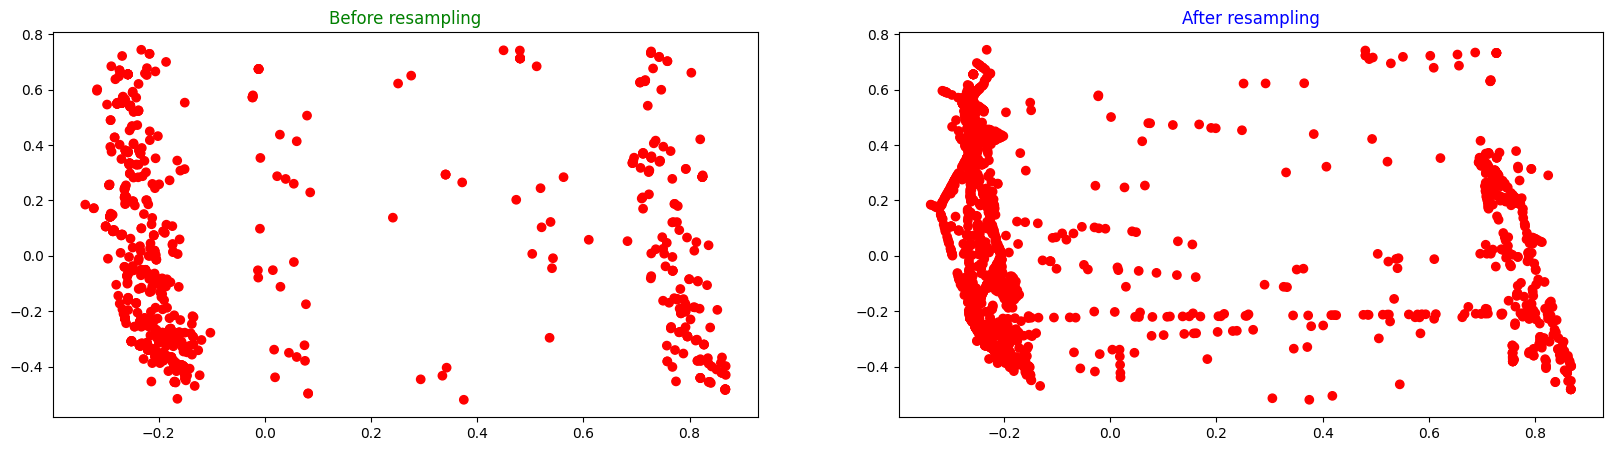

In [26]:
X_resampled, Y_resampled = resample(smoteenn, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, Y_resampled, 0)

In [27]:
knn_balanced = KNeighborsClassifier(n_neighbors=10)

In [28]:
knn_balanced.fit(X_resampled,Y_resampled)

KNeighborsClassifier(n_neighbors=10)

In [29]:
report(knn_balanced,X_resampled,Y_resampled)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

         4.0       0.95      0.99      0.97       467
         5.0       0.95      0.98      0.96       425
         6.0       0.88      0.88      0.88       192
         7.0       0.84      0.60      0.70       123
         8.0       0.94      0.88      0.91       296
         9.0       0.95      0.99      0.97       488

    accuracy                           0.94      1991
   macro avg       0.92      0.89      0.90      1991
weighted avg       0.93      0.94      0.93      1991

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on training data 
---------------------------------------------------------------------------------
     4    5    6   7    8    9
4  460    1    0   0    0    6
5    9  416  

In [64]:
report(knn_balanced,X_test,Y_test,"test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

         4.0       0.00      0.00      1.00         8
         5.0       0.10      0.50      0.16        16
         6.0       0.26      0.22      0.24        95
         7.0       0.67      0.18      0.29       263
         8.0       0.20      0.39      0.26        51
         9.0       0.04      0.40      0.08         5

    accuracy                           0.23       438
   macro avg       0.21      0.28      0.34       438
weighted avg       0.48      0.23      0.28       438

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on test data 
---------------------------------------------------------------------------------
    4   5   6   7   8   9
4   0   7   1   0   0   0
5   2   8   2   3   1   0
6  22

In [31]:
#Preprilagodjavanje
#Parameter tuning

In [32]:
estimator2 = GridSearchCV(KNeighborsClassifier(), param_grid=params_grid, cv=3, verbose=4)
estimator2.fit(X_resampled,Y_resampled)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.938 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.914 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.916 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.965 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.956 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.958 total time=   0.0s


[CV 1/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.928 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.902 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.911 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=2, weights=distance;, score=0.958 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=2, weights=distance;, score=0.950 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=2, weights=distance;, score=0.955 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=6, p=1, weights=uniform;, score=0.922 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=6, p=1, weights=uniform;, score=0.895 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=6, p=1, weights=uniform;, score=0.899 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=6, p=1, weights=distance;, score=0.965 total time=   0.0s
[CV 2/3] END alg

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'n_neighbors': range(5, 20), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [33]:
print(estimator2.best_params_)
print(estimator2.best_score_)

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.9598181564871856


In [34]:
report(estimator2.best_estimator_,X_resampled,Y_resampled)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

         4.0       1.00      1.00      1.00       467
         5.0       1.00      1.00      1.00       425
         6.0       1.00      1.00      1.00       192
         7.0       1.00      1.00      1.00       123
         8.0       1.00      1.00      1.00       296
         9.0       1.00      1.00      1.00       488

    accuracy                           1.00      1991
   macro avg       1.00      1.00      1.00      1991
weighted avg       1.00      1.00      1.00      1991

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on training data 
---------------------------------------------------------------------------------
     4    5    6    7    8    9
4  467    0    0    0    0    0
5    0  425

In [35]:
report(estimator2.best_estimator_,X_test,Y_test,"test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

         4.0       0.00      0.00      1.00         8
         5.0       0.12      0.38      0.18        16
         6.0       0.25      0.22      0.23        95
         7.0       0.71      0.33      0.45       263
         8.0       0.20      0.41      0.27        51
         9.0       0.03      0.20      0.05         5

    accuracy                           0.31       438
   macro avg       0.22      0.26      0.36       438
weighted avg       0.51      0.31      0.38       438

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on test data 
---------------------------------------------------------------------------------
    4   5   6   7   8   9
4   0   7   0   0   1   0
5   2   6   1   5   2   0
6  18

In [36]:
from sklearn.ensemble import BaggingClassifier

baggingKnn = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=20)
baggingKnn.fit(X_train, Y_train)

report_imbalanced(baggingKnn, X_train, Y_train)
report_imbalanced(baggingKnn, X_test, Y_test, "test")

Classification report for model BaggingClassifier on training data
Accuracy: 0.7105855855855856
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.60      0.20      1.00      0.30      0.45      0.18        15
        5.0       0.47      0.22      0.99      0.30      0.47      0.20        32
        6.0       0.67      0.42      0.94      0.52      0.63      0.38       194
        7.0       0.73      0.92      0.49      0.82      0.67      0.47       532
        8.0       0.68      0.42      0.97      0.52      0.64      0.39       104
        9.0       0.43      0.27      1.00      0.33      0.52      0.25        11

avg / total       0.70      0.71      0.68      0.68      0.65      0.43       888

---------------------------------------------------------------------------------
Confusion matrix for model BaggingClassifier on training data 
----------

In [37]:
# za balansirane pod
baggingKnn_balanced = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=20)
baggingKnn_balanced.fit(X_resampled, Y_resampled)

report(baggingKnn_balanced, X_resampled, Y_resampled)
report(baggingKnn_balanced, X_test, Y_test, "test")

Classification report for model BaggingClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

         4.0       0.99      1.00      0.99       467
         5.0       0.99      0.99      0.99       425
         6.0       0.94      0.95      0.94       192
         7.0       0.95      0.85      0.90       123
         8.0       0.96      0.96      0.96       296
         9.0       0.99      1.00      0.99       488

    accuracy                           0.98      1991
   macro avg       0.97      0.96      0.96      1991
weighted avg       0.98      0.98      0.98      1991

---------------------------------------------------------------------------------
Confusion matrix for model BaggingClassifier on training data 
---------------------------------------------------------------------------------
     4    5    6    7    8    9
4  466    0    0    0    0    1
5    2  420    0 

In [38]:
#posebno cu porediti modele na balansiranim i na nebalansiranim klasama  


In [39]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape

(438, 6)

In [40]:
n_classes=6

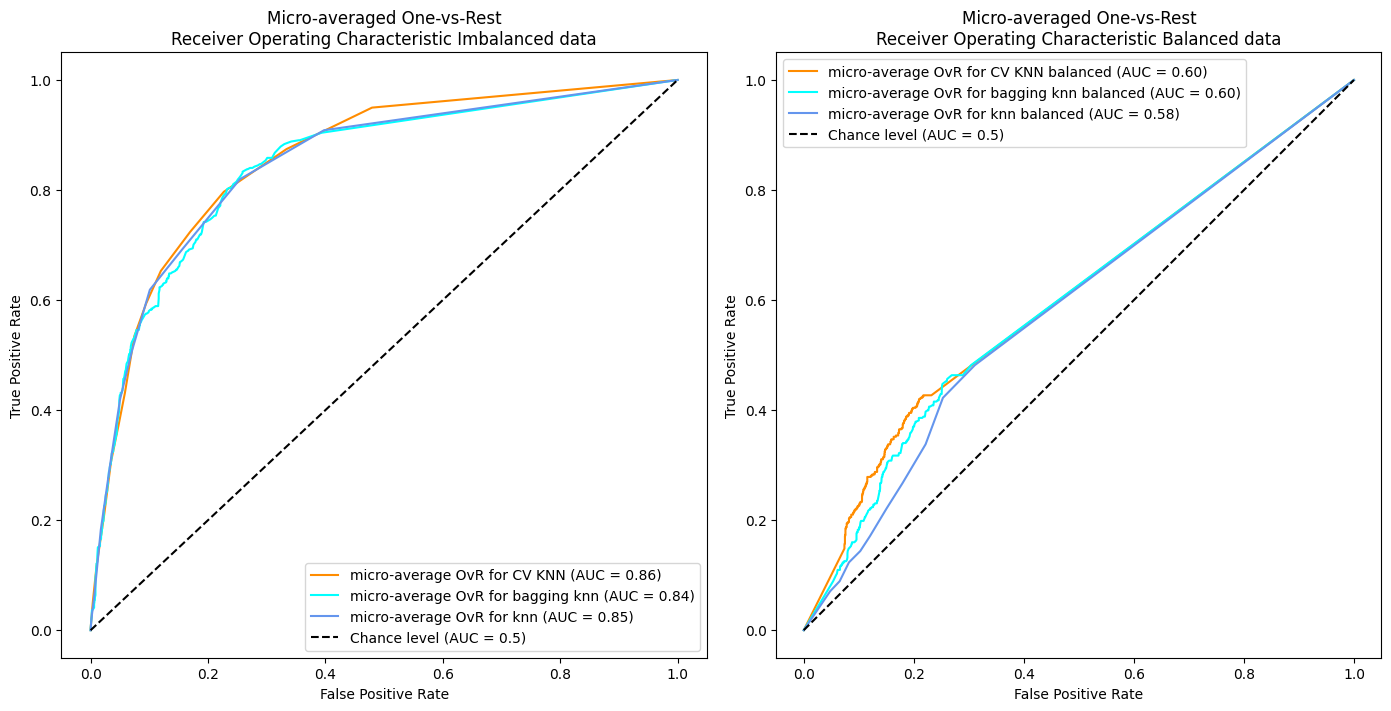

In [41]:
#kalkulisemo micro avg - daje istu tezinu svakom sample-u 
y_score=estimator.best_estimator_.fit(X_train, Y_train).predict_proba(X_test)
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),layout="constrained" )
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR for CV KNN",
    color="darkorange",
    plot_chance_level=False,
    ax=ax1
    
)
y_score=baggingKnn.fit(X_train, Y_train).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR for bagging knn",
    color="aqua",
    plot_chance_level=False,
    ax=ax1
    
)
y_score=knn.fit(X_train, Y_train).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR for knn",
    color="cornflowerblue",
    plot_chance_level=True,
    ax=ax1
    
)
y_score=estimator2.best_estimator_.fit(X_resampled, Y_resampled).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR for CV KNN balanced",
    color="darkorange",
    plot_chance_level=False,
    ax=ax2
    
)
y_score=baggingKnn_balanced.fit(X_resampled, Y_resampled).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR for bagging knn balanced",
    color="aqua",
    plot_chance_level=False,
    ax=ax2
    
)
y_score=knn_balanced.fit(X_resampled, Y_resampled).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR for knn balanced",
    color="cornflowerblue",
    plot_chance_level=True,
    ax=ax2
    
)

plt.axis("square")
ax1.set_xlabel("False Positive Rate")
ax2.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax1.set_title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic Imbalanced data")
ax2.set_title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic Balanced data")

plt.legend()
plt.show()

In [42]:
def macro_avg(y_onehot_test,y_score): #scikitlearn
    fpr=[0 for i in range(0,n_classes)]
    tpr=[0 for i in range(0,n_classes)]
    roc_auc=[0 for i in range(0,n_classes)]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr = fpr_grid
    tpr = mean_tpr
    roc_auc= auc(fpr, tpr)
    #print(fpr)
    return fpr, tpr, roc_auc

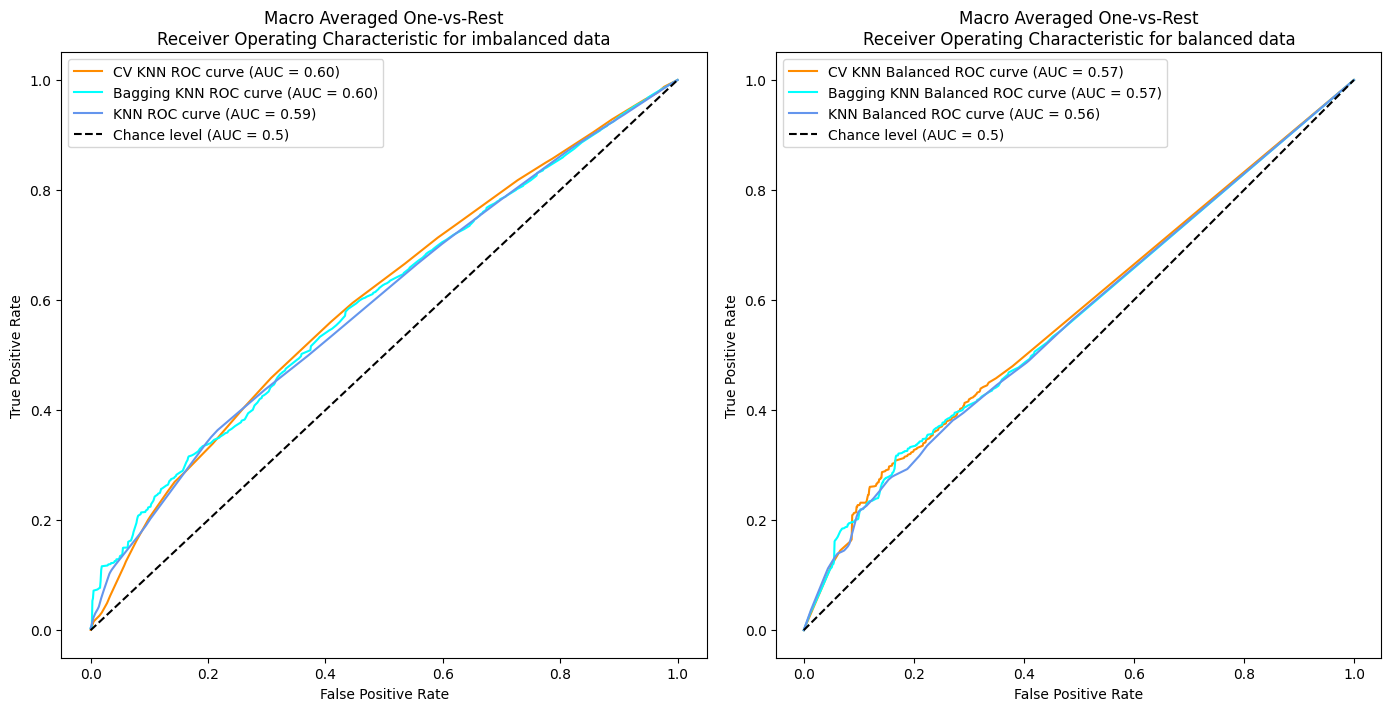

In [43]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),layout="constrained" )
y_score=estimator.best_estimator_.fit(X_train, Y_train).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"CV KNN ROC curve (AUC = {roc_auc:.2f})",
    color="darkorange",
    
    
)
y_score=baggingKnn.fit(X_train, Y_train).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"Bagging KNN ROC curve (AUC = {roc_auc:.2f})",
    color="aqua",
    
    
)
y_score=knn.fit(X_train, Y_train).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"KNN ROC curve (AUC = {roc_auc:.2f})",
    color="cornflowerblue",
    
    
)
ax1.plot([0, 1], [0, 1], label='Chance level (AUC = 0.5)', color='black',linestyle='dashed')


y_score=estimator2.best_estimator_.fit(X_resampled, Y_resampled).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax2.plot(
    fpr,
    tpr,
    label=f"CV KNN Balanced ROC curve (AUC = {roc_auc:.2f})",
    color="darkorange",
    
    
)
y_score=baggingKnn_balanced.fit(X_resampled, Y_resampled).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax2.plot(
    fpr,
    tpr,
    label=f"Bagging KNN Balanced ROC curve (AUC = {roc_auc:.2f})",
    color="aqua",
    
    
)
y_score=knn_balanced.fit(X_resampled, Y_resampled).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax2.plot(
    fpr,
    tpr,
    label=f"KNN Balanced ROC curve (AUC = {roc_auc:.2f})",
    color="cornflowerblue",
    
    
)
ax2.plot([0, 1], [0, 1], label='Chance level (AUC = 0.5)', color='black',linestyle='dashed')

plt.axis("square")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax1.set_title("Macro Averaged One-vs-Rest\nReceiver Operating Characteristic for imbalanced data")
ax2.set_title("Macro Averaged One-vs-Rest\nReceiver Operating Characteristic for balanced data")
ax1.legend()
ax2.legend()
plt.show()

In [44]:
#Najbolje nerformanse daje CV KNN za nebalansirane podatke

In [45]:
import joblib
joblib.dump(estimator.best_estimator_, r'C:\Users\Administrator\2023_Data_Mining_Coffee_Quality_Dataset\models\classification\cv_knn.pkl')

['C:\\Users\\Administrator\\2023_Data_Mining_Coffee_Quality_Dataset\\models\\classification\\cv_knn.pkl']

In [46]:
#one hot encoding and PCA

In [48]:
from sklearn.preprocessing import OneHotEncoder

hotencoder=OneHotEncoder(feature_name_combiner="concat")
encoder_df=pd.DataFrame(hotencoder.fit_transform(X[["Country.of.Origin","Variety","Processing.Method","Color"]]).toarray(),columns=hotencoder.get_feature_names_out())

In [49]:
X=X.join(encoder_df)
X.drop(labels=["Country.of.Origin","Variety","Processing.Method","Color"],axis=1,inplace=True)

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.33, random_state=42)

In [52]:
scaler = StandardScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [53]:
from sklearn.decomposition import PCA
pca = PCA(2)

In [54]:
pca.fit(X_train1)


PCA(n_components=2)

In [55]:
X_train1=pca.transform(X_train1)
X_test1=pca.transform(X_test1)


In [62]:
pca.explained_variance_ratio_

array([0.03855147, 0.03449048])

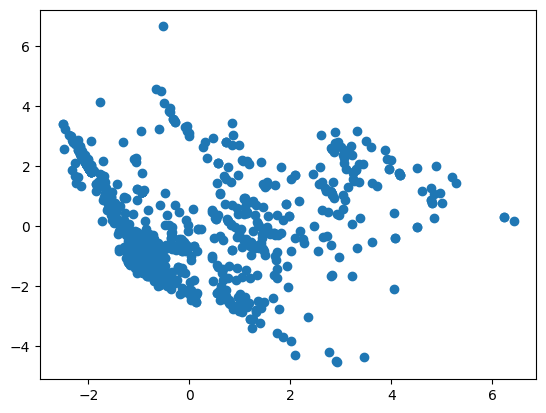

In [67]:

_=plt.scatter(X_train1[:,0],X_train1[:,1])

In [56]:
estimator_pca = GridSearchCV(KNeighborsClassifier(), param_grid=params_grid, cv=3, verbose=4)

In [58]:
estimator_pca.fit(X_train1,y_train1)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.524 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.510 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=0.534 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.500 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.500 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=0.517 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.517 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.500 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, p=2, weights=uniform;, score=0.530 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, p=2, wei

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'n_neighbors': range(5, 20), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [59]:
print(estimator_pca.best_params_)
print(estimator_pca.best_score_)

{'algorithm': 'auto', 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}
0.5788288288288288


In [60]:
report_imbalanced(estimator_pca.best_estimator_,X_train1,y_train1)

Classification report for model KNeighborsClassifier on training data
Accuracy: 0.5990990990990991
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      0.00      1.00      0.00      0.00      0.00        17
        5.0       1.00      0.00      1.00      0.00      0.00      0.00        33
        6.0       0.54      0.13      0.97      0.21      0.35      0.11       197
        7.0       0.60      0.97      0.11      0.74      0.33      0.12       517
        8.0       0.54      0.06      0.99      0.11      0.25      0.06       109
        9.0       1.00      0.00      1.00      0.00      0.00      0.00        15

avg / total       0.61      0.60      0.48      0.49      0.30      0.10       888

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on training data 
----

In [68]:
report_imbalanced(estimator_pca.best_estimator_,X_test1,y_test1,"test")

Classification report for model KNeighborsClassifier on test data
Accuracy: 0.6095890410958904
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      0.00      1.00      0.00      0.00      0.00         6
        5.0       1.00      0.00      1.00      0.00      0.00      0.00        15
        6.0       0.26      0.07      0.95      0.10      0.25      0.06        92
        7.0       0.64      0.94      0.09      0.76      0.30      0.10       278
        8.0       0.11      0.02      0.98      0.04      0.15      0.02        46
        9.0       0.00      0.00      1.00      1.00      0.00      0.00         1

avg / total       0.52      0.61      0.41      0.51      0.26      0.07       438

---------------------------------------------------------------------------------
Confusion matrix for model KNeighborsClassifier on test data 
------------

In [69]:
label_binarizer = LabelBinarizer().fit(y_train1)
y_onehot_test1 = label_binarizer.transform(y_test1)
y_onehot_test1.shape

(438, 6)

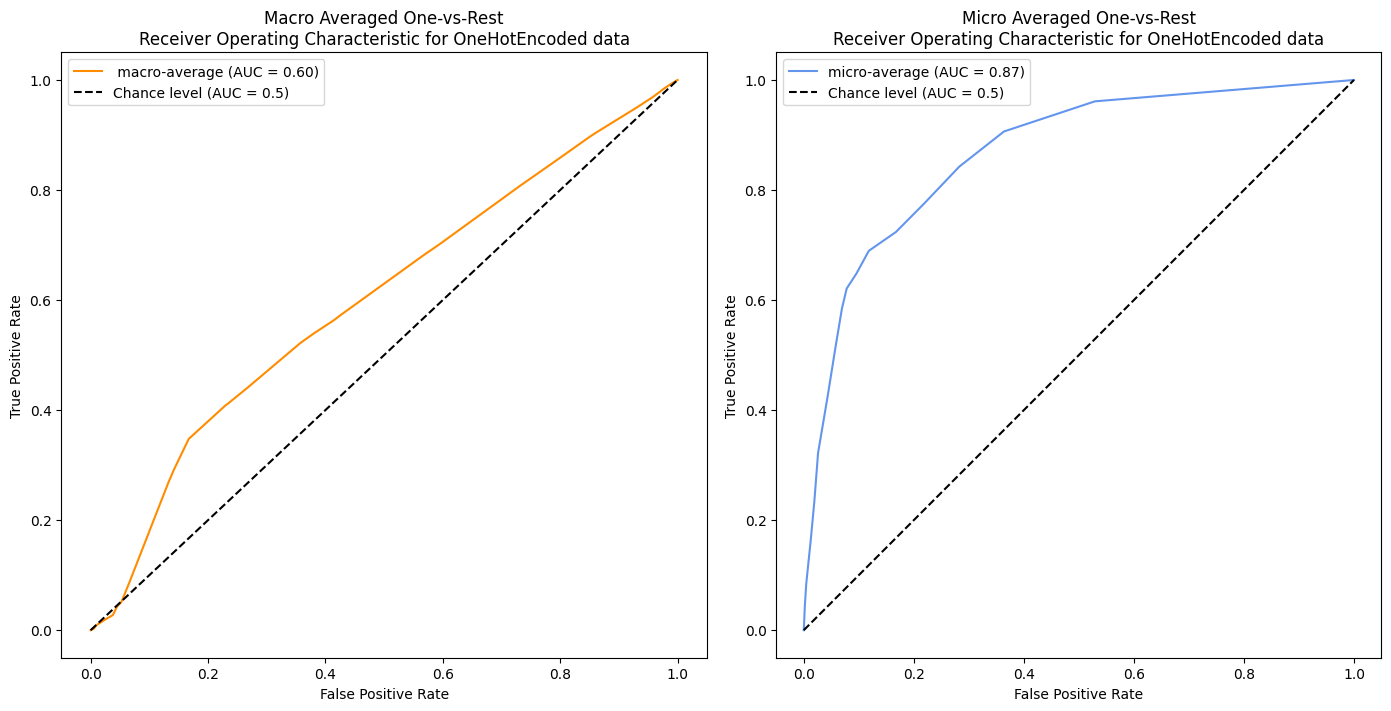

In [72]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14, 7),layout="constrained" )
y_score=estimator_pca.best_estimator_.fit(X_train1, y_train1).predict_proba(X_test1)
fpr,tpr,roc_auc=macro_avg(y_onehot_test1,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f" macro-average (AUC = {roc_auc:.2f})",
    color="darkorange",
    
    
)
#y_score=knn_balanced.fit(X_resampled, Y_resampled).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test1.ravel(),
    y_score.ravel(),
    name="micro-average",
    color="cornflowerblue",
    plot_chance_level=True,
    ax=ax2
    
)
ax1.plot([0, 1], [0, 1], label='Chance level (AUC = 0.5)', color='black',linestyle='dashed')
plt.axis("square")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax1.set_title("Macro Averaged One-vs-Rest\nReceiver Operating Characteristic for OneHotEncoded data")
ax2.set_title("Micro Averaged One-vs-Rest\nReceiver Operating Characteristic for OneHotEncoded data")
ax1.legend()
ax2.legend()
plt.show()